This project explores the [chinook database](https://github.com/lerocha/chinook-database), a well-known database containing fictional data about a digital media store, useful for practicing in SQL, using the sqlite3 python module and pandas for converting the database tables to dataframes, combining the the speed in queries of the SQL language to the pandas ability to create useful visualizations.<br>

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [3]:
def run_command(q):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(q)

In [4]:
def show_tables():
    query='SELECT name, type FROM sqlite_master WHERE type in ("table", "view")'
    df = run_query(query)
    print("The chinook database contains the following tables")
    print(df.head())

In [5]:
show_tables()

The chinook database contains the following tables
       name   type
0     album  table
1    artist  table
2  customer  table
3  employee  table
4     genre  table


### Music Genres in USA

Let's see what genres are sold to USA customers.

In [6]:
usa_query= """WITH music_in_usa AS(
SELECT  g.name music_genre, il.quantity quantity, billing_country
FROM invoice_line il
INNER JOIN invoice i ON il.invoice_id = i.invoice_id
INNER JOIN track t ON il.track_id = t.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
WHERE i.billing_country="USA"),

total AS(
SELECT SUM(quantity)total_tracks, billing_country FROM music_in_usa)

SELECT music_genre, SUM(quantity)number_of_tracks, CAST(SUM(quantity) AS Float)/total_tracks * 100 percentage
FROM music_in_usa miu
JOIN total ON miu.billing_country = total.billing_country
GROUP BY music_genre
ORDER BY percentage DESC
"""

In [7]:
usa_genres = run_query(usa_query)

In [8]:
usa_genres

,music_genre,number_of_tracks,percentage
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Pop,22,2.093245
7,Latin,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


In [9]:
genres_labels = usa_genres['music_genre'].tolist()
genres_percent = usa_genres['percentage'].tolist()
positions = np.arange(len(genres_labels)) + 1

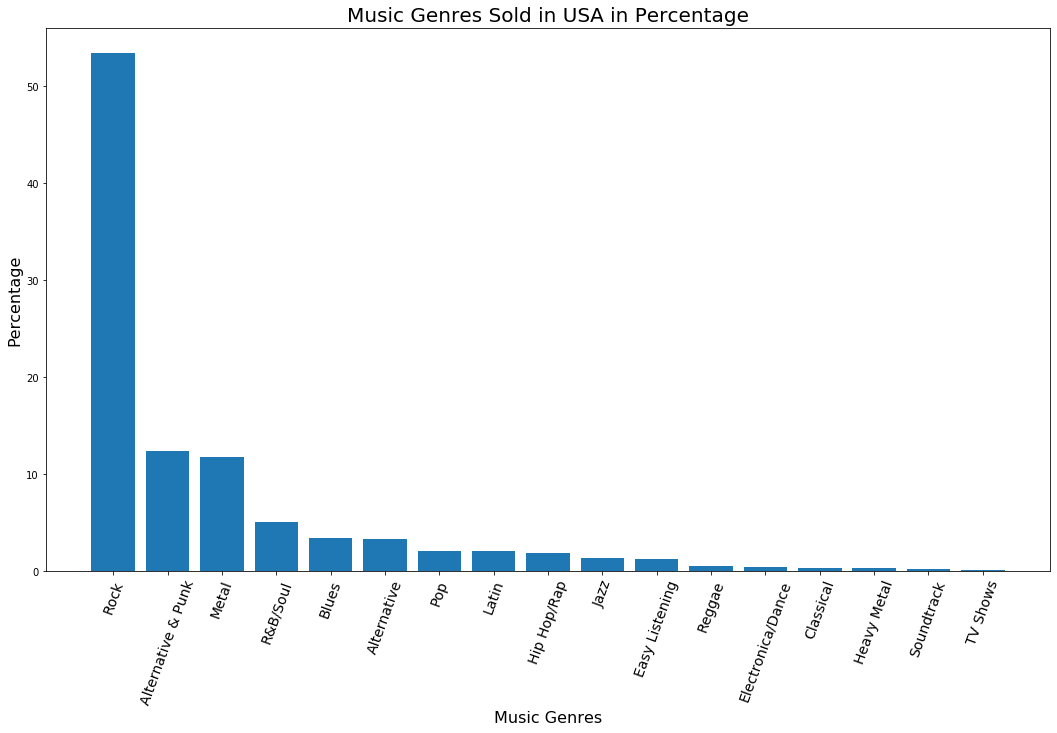

In [10]:
plt.figure(figsize=(18,10))
plt.bar(positions, genres_percent, align="center")
plt.xticks(positions, genres_labels, rotation=70,fontsize=14)
plt.ylabel("Percentage", fontsize=16)
plt.xlabel("Music Genres", fontsize=16)
plt.title("Music Genres Sold in USA in Percentage", fontsize=20);

The most sold genres is USA is clearly Rock which accounts for more than half of all the music tracks sold (53%).

### Best Support Sales Agent

Every customer in the chinook database has a sales support agent assigned, let's see who is the best one in terms of dollar amount and average sale.

In [11]:
agent_query = """WITH total_sales_per_client AS(
SELECT SUM(i.total) total_sales, c.support_rep_id agent_id, i.customer_id 
FROM invoice i
INNER JOIN customer c ON c.customer_id = i.customer_id
GROUP BY i.customer_id, agent_id
)

SELECT e.first_name ||" " ||e.last_name agent_name, e.title role,
SUM(total_sales) sales,
COUNT(ts.customer_id) number_of_customers,
SUM(total_sales)/COUNT(ts.customer_id) average_sale_per_client
FROM employee e 
INNER JOIN total_sales_per_client ts ON e.employee_id = ts.agent_id
GROUP BY agent_name
ORDER BY sales DESC"""

In [12]:
agent_df = run_query(agent_query)
agent_df

,agent_name,role,sales,number_of_customers,average_sale_per_client
0,Jane Peacock,Sales Support Agent,1731.51,21,82.452857
1,Margaret Park,Sales Support Agent,1584.00,20,79.200000
2,Steve Johnson,Sales Support Agent,1393.92,18,77.440000


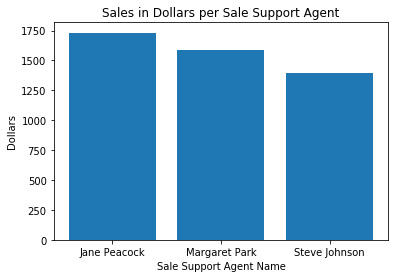

In [13]:
agents = agent_df['agent_name'].tolist()
sales = agent_df['sales'].tolist()
agent_pos= np.arange(len(agents)) + 1
plt.title("Sales in Dollars per Sale Support Agent")
plt.ylabel("Dollars")
plt.xlabel("Sale Support Agent Name")
plt.xticks(agent_pos, agents)
plt.bar(agent_pos, sales, align="center");

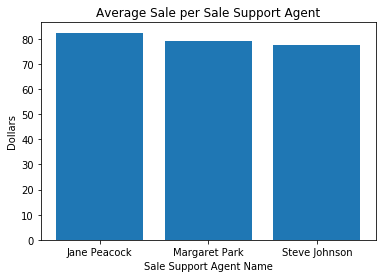

In [14]:
avg_sales = agent_df['average_sale_per_client'].tolist()
plt.title("Average Sale per Sale Support Agent")
plt.ylabel("Dollars")
plt.xlabel("Sale Support Agent Name")
plt.xticks(agent_pos, agents)
plt.bar(agent_pos, avg_sales, align="center");

The best Sales Support Agent is Jane Peacock with a total of sales of about 1731 dollars. Jane Peacock has also more customers to follow than the other two Sales Support Agents, but on average she sells slightly more than the other two per customer, 82 dollars, againts 79 of Margaret park and 77 of Steve Johnson.

### Sales by Country

Let'see the total amount of customers, the total value of sales, the average value of sales per customer and the average order value for each country.

In [15]:
query_country="""WITH spenders AS (
SELECT COUNT(i.customer_id) number_of_orders,COUNT(c.customer_id) number_of_customers,
    c.customer_id customer_id, SUM(i.total )total_spent,c.country country,
SUM(i.total)/COUNT(i.customer_id) average_spent
FROM customer c
INNER JOIN invoice i
ON c.customer_id = i.customer_id
GROUP BY country, c.customer_id),
country_customers AS (
    SELECT COUNT(country) number_of_customers, country
FROM spenders
GROUP BY country
ORDER BY number_of_customers DESC
),

spenders_by_country AS(
SELECT 
CASE
    WHEN cc.number_of_customers > 1 THEN cc.country
    ELSE "Other"
    END AS country_name,
COUNT(cc.number_of_customers) total_customers,
SUM(number_of_orders)number_of_orders, SUM(total_spent)total_value_of_sales,
SUM(total_spent)/SUM(number_of_orders) average_sale, 
SUM(number_of_orders)/CAST(COUNT(cc.number_of_customers)AS Float) avg_number_of_orders_per_customer
FROM spenders s
JOIN country_customers cc ON s.country = cc.country
GROUP BY country_name
ORDER BY total_value_of_sales DESC, cc.number_of_customers)

SELECT 
country_name, total_customers, number_of_orders, total_value_of_sales,
    average_sale, avg_number_of_orders_per_customer, total_value_of_sales/total_customers avg_customer_value
FROM (
    SELECT country_name, total_customers, number_of_orders, total_value_of_sales,
    average_sale, avg_number_of_orders_per_customer,
    CASE
    WHEN country_name = "Other" THEN 1
    ELSE 0
    END AS ordering
    FROM spenders_by_country
)
ORDER BY ordering """

In [16]:
country_df = run_query(query_country)
country_df

,country_name,total_customers,number_of_orders,total_value_of_sales,average_sale,avg_number_of_orders_per_customer,avg_customer_value
0,USA,13,131,1040.49,7.942672,10.076923,80.037692
1,Canada,8,76,535.59,7.047237,9.500000,66.948750
2,Brazil,5,61,427.68,7.011148,12.200000,85.536000
3,France,5,50,389.07,7.781400,10.000000,77.814000
4,Germany,4,41,334.62,8.161463,10.250000,83.655000
5,Czech Republic,2,30,273.24,9.108000,15.000000,136.620000
6,United Kingdom,3,28,245.52,8.768571,9.333333,81.840000
7,Portugal,2,29,185.13,6.383793,14.500000,92.565000
8,India,2,21,183.15,8.721429,10.500000,91.575000
9,Other,15,147,1094.94,7.448571,9.800000,72.996000


USA is country witht highest amount of sales,the largest number of customers (13) and the highest value per customers: on average each customer spends about 80 dollar in total.

### Single Track vs Full Album

Let's see what proportion of invoices contains all the tracks from an album.

In [17]:
query_albums = """WITH first_tracks AS(
SELECT il.invoice_id invoice_id,
MIN(il.track_id) first_track_id
FROM invoice_line il
GROUP BY invoice_id),

albums_bought AS (

SELECT ft.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT track.album_id FROM track 
                                      WHERE track.track_id = ft.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT invoice_line.track_id FROM invoice_line 
                  WHERE invoice_line.invoice_id = ft.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT invoice_line.track_id FROM invoice_line 
                  WHERE invoice_line.invoice_id = ft.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT track.album_id FROM track
                                      WHERE track.track_id = ft.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
             END AS "is_album"
    FROM first_tracks ft)



SELECT CAST(COUNT(first_track_id)AS Float) /(SELECT COUNT(*) FROM invoice)*100 percentage, is_album
FROM albums_bought
GROUP by is_album

"""

In [18]:
run_query(query_albums)

,percentage,is_album
0,81.433225,no
1,18.566775,yes


About 18.6 % of invoices are for buying all the songs from an album, so this kind of sells are quite relevant for the chinook store.